# Bulldozer Price Prediction

### Kaggle competition :  Blue Book for Bulldozers

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview)

The techniques used in here have been inspired and adapted from [the fast.ai machine learning course](https://course18.fast.ai/ml).
## Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?
## Data

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).
## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

In [1]:
# Import data analysis tools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

## Features shown in data Dictionary

In [2]:
data_dict = pd.read_excel("../data/bluebook-for-bulldozers/Data Dictionary.xlsx",)
data_dict.drop('Unnamed: 2',axis=1,inplace=True)

In [3]:
data_dict

,Variable,Description
0,SalesID,unique identifier of a particular sale of a ...
1,MachineID,identifier for a particular machine; machin...
2,ModelID,identifier for a unique machine model (i.e. ...
3,datasource,source of the sale record; some sources are...
4,auctioneerID,"identifier of a particular auctioneer, i.e. ..."
5,YearMade,year of manufacturer of the Machine
6,MachineHoursCurrentMeter,current usage of the machine in hours at tim...
7,UsageBand,"value (low, medium, high) calculated compari..."
8,Saledate,time of sale
9,Saleprice,cost of sale in USD


In [4]:
# import training and validation set at same time
df = pd.read_csv("../data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False)

In [5]:
# check head
df.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1139255,26500.0,1001274,4605,121,3.0,2004,508.0,Low,12/18/2008 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1139256,21000.0,772701,1937,121,3.0,1993,11540.0,High,8/26/2004 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
7,1139261,27000.0,902002,3539,121,3.0,2001,4883.0,High,11/17/2005 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1139272,21500.0,1036251,36003,121,3.0,2008,302.0,Low,8/27/2009 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
9,1139275,65000.0,1016474,3883,121,3.0,1000,20700.0,Medium,8/9/2007 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [34]:
# check info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

We can seee 52 columns with 412698 entries, with mainly string variables and some numbers. There is also missing values. 


In [31]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SalesID,412698.0,2.011161e+06,1.080068e+06,1139246.0,1421897.75,1645852.5,2261012.50,6333349.0
SalePrice,412698.0,3.121518e+04,2.314174e+04,4750.0,14500.00,24000.0,40000.00,142000.0
MachineID,412698.0,1.230061e+06,4.539533e+05,0.0,1088593.25,1284397.0,1478079.25,2486330.0
ModelID,412698.0,6.947202e+03,6.280825e+03,28.0,3261.00,4605.0,8899.00,37198.0
datasource,412698.0,1.351694e+02,9.646749e+00,121.0,132.00,132.0,136.00,173.0
auctioneerID,392562.0,6.585268e+00,1.715841e+01,0.0,1.00,2.0,4.00,99.0
YearMade,412698.0,1.899050e+03,2.921902e+02,1000.0,1985.00,1995.0,2001.00,2014.0
MachineHoursCurrentMeter,147504.0,3.522988e+03,2.716993e+04,0.0,0.00,0.0,3209.00,2483300.0


In [40]:
# check nulls as % of total entries
(df.isnull().sum()/len(df))*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
saledate                     0.000000
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission

Clearly see lots of columns with alot of nulls!!! greater than 75%.\
**We will explore further later** 

# EDA

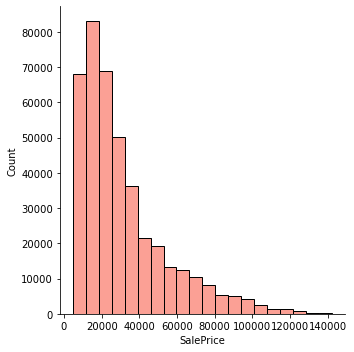

In [49]:
# displot of sales price!!!
sns.displot(x="SalePrice",data=df,bins=20,color="salmon")

Seee Bi-modal distribution with most bulldozer prices being arount the 20k range

##### Explore the date  of sales

In [6]:
# convert saledate string to datetime object
df["saledate"] = pd.to_datetime(df["saledate"])
df["saledate"]

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [7]:
# add new columns year and month instead of saledate
df["saleyear"] = df["saledate"].apply(lambda date: date.year)
df["salemonth"] = df["saledate"].apply(lambda date: date.month)
df[["saleyear","salemonth"]]

,saleyear,salemonth
0,2006,11
1,2004,3
2,2004,2
3,2011,5
4,2009,7
...,...,...
412693,2012,3
412694,2012,1
412695,2012,1
412696,2012,3


In [8]:
# remove original saledate column 1
df.drop("saledate",axis=1,inplace=True)

<AxesSubplot:xlabel='saleyear'>

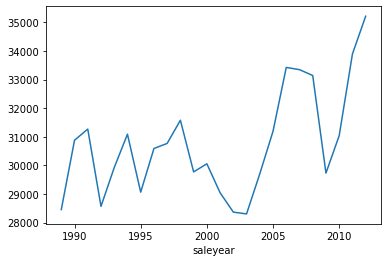

In [9]:
# check relationship between saleprice and year
df.groupby("saleyear").mean()["SalePrice"].plot()

<AxesSubplot:xlabel='salemonth'>

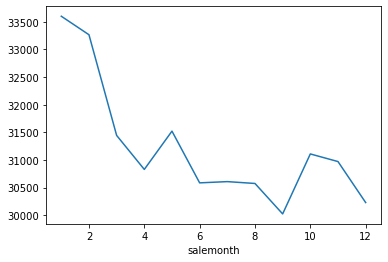

In [7]:
# check relationship between saleprice and month
df.groupby("salemonth").mean()["SalePrice"].plot()

- Price seems to increase as years increase 
- Price seems to go down as months go from jan to december

<AxesSubplot:xlabel='saleyear', ylabel='count'>

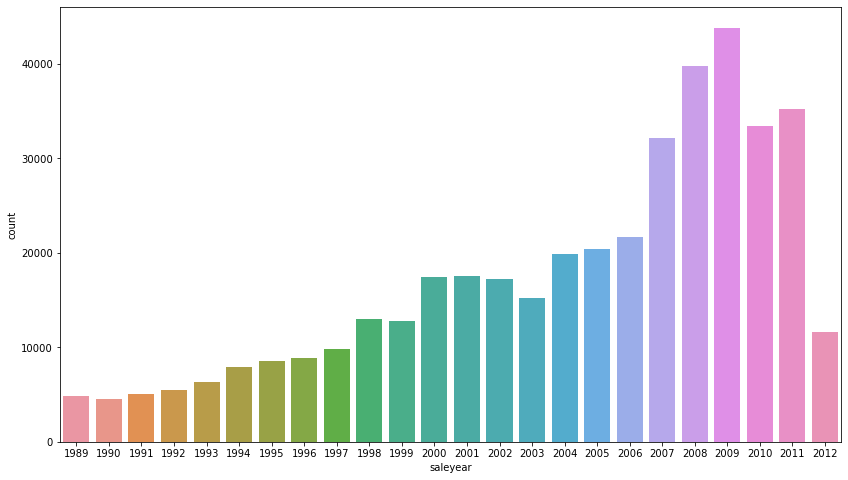

In [67]:
# check sales by year count 
# most bulldozers sold in recent years
plt.figure(figsize=(14,8))
sns.countplot(x="saleyear",data=df)

<AxesSubplot:xlabel='salemonth', ylabel='count'>

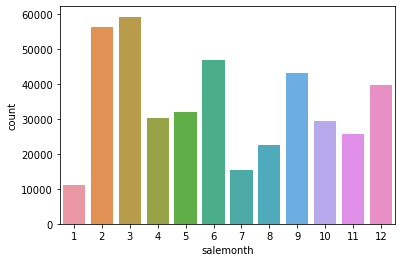

In [63]:
# check sales by month count 
sns.countplot(x="salemonth",data=df)

In [68]:
# check states 
df["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

<AxesSubplot:>

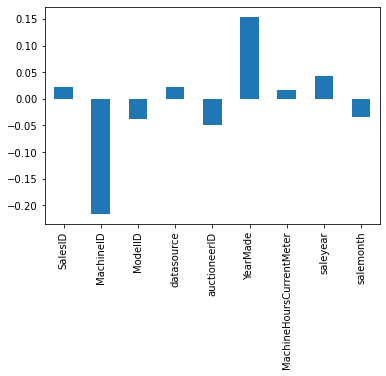

In [114]:
# check correlation with sales price to see most correlated features
df.corr()["SalePrice"].drop("SalePrice").plot(kind="bar")                                      
                                             

Machine ID most decorrelated and Year made most correlated 

In [115]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,521D,...,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,950FII,...,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7


<AxesSubplot:xlabel='YearMade'>

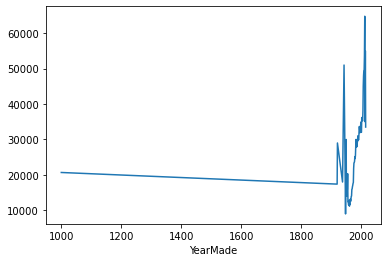

In [116]:
# check year made vs sale price 
df.groupby("YearMade").mean()["SalePrice"].plot()

Looks like an odd distribution. But prices higher near end 

<Figure size 864x432 with 0 Axes>

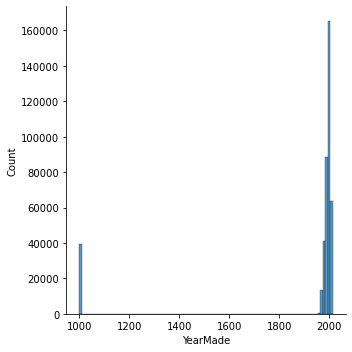

In [130]:
# check counts per year made 
plt.figure(figsize=(12,6))
sns.displot(x="YearMade",data=df,bins=100)

See most are near 2000, but there is large peak at 1000!!!! which is odd

### Deal with String features
    # Convert to cataogircal if we should
    # Drop if unnecesary
    # feature engineer

In [133]:
# check all string objects that need to be converted!!!
df.select_dtypes(["object"]).head()

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
# all string variables
list(df.select_dtypes(["object"]).columns)

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [10]:
# make a temporary dataset as a copy rather than working on original
df_temp = df.copy()

In [11]:
## This will turn all of the string values into category values!!
for label,content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [12]:
# check info to see change 
# all string variables in pandas category now
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [13]:
# see converted to catogries
df_temp.select_dtypes(include="category")

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Texas,TEX,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,NaN,30NX2,30,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Florida,TEX,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Texas,TEX,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


Category values are numbers(codes) under the hood!!!!!! So we actually have nums that look like strings

In [14]:
# See each state is assigned a code!!!!! Thus its a number
df_temp["UsageBand"].cat.codes

0         1
1         1
2         0
3         0
4         2
         ..
412693   -1
412694   -1
412695   -1
412696   -1
412697   -1
Length: 412698, dtype: int8

## Now we can deal with null values as all data numeric
> WE cannt have any nulls passed into model

In [15]:
# recheck nulls
(df_temp.isnull().sum()/len(df_temp))*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

#### Data with nulls greater than 75% is unreliable!!! So will drop those columns 

In [16]:
# get all columns with nulls greater than 75%
lots_of_nulls = []
for label,content in df_temp.items():
    if (content.isnull().sum())/len(df) > .75:
        lots_of_nulls.append(label)


In [17]:
# print out list 
lots_of_nulls

['UsageBand',
 'fiModelSeries',
 'fiModelDescriptor',
 'Pad_Type',
 'Stick',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Pushblock',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [18]:
# drop all columns with more than 75% nulls 
df_temp.drop(lots_of_nulls,axis=1,inplace=True)

#### Fill Numerical data  first  now 

In [19]:
# get numerical columns with nulls
for label,content in df_temp.items():
    # check if numeric data type
    if pd.api.types.is_numeric_dtype(content):
        # check if isnull - sum dosent = 0
        if content.isnull().sum() != 0 :
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [20]:
# another wa to fully see ones that are numeric
df_temp.select_dtypes(include=np.number).isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
saleyear                         0
salemonth                        0
dtype: int64

##### We will fill in numeric cols nulls with median of columns !!! Since it is more robust than mean

In [21]:
# check median of 2 null numeric cols 
df_temp["auctioneerID"].median(),df_temp["MachineHoursCurrentMeter"].median()

(2.0, 0.0)

In [22]:
# get numerical columns with nulls
for label,content in df_temp.items():
    # check if numeric data type
    if pd.api.types.is_numeric_dtype(content):
        # check if isnull - sum dosent = 0
        if content.isnull().sum() != 0:
            # add binary column to show if missing or not 
            df_temp[f"{label}_is_missing"] = content.isnull()
            # fill missing values with median
            df_temp[label] = content.fillna(content.median(),inplace=True)
            

In [23]:
# check if null cols again 
df_temp.select_dtypes(np.number).isnull().sum()

SalesID       0
SalePrice     0
MachineID     0
ModelID       0
datasource    0
YearMade      0
saleyear      0
salemonth     0
dtype: int64

In [24]:
# check missing col
df_temp["MachineHoursCurrentMeter_is_missing"].value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

good no null number columns now.\
We added a missing values column because there may be a reason for this!!! Thus we have columns to illustrate this. 

### Filling and turning categorical variables to numbers
##### Using Orindal Encoding here for ease of use. It would be better to convert all catagorical variables to dummy variables using OneHotEncoding  
> For categorical variables, it imposes an ordinal relationship(order) where no such relationship may exist. This can cause problems and a one-hot encoding may be used instead.


In [25]:
            
# get all catogorical variables 
for label,content in df_temp.items():
    # check cols which arn't numeric
    if not pd.api.types.is_numeric_dtype(content):
        # add binary column again to show missing values
        df_temp[label+"_is_missing"] = content.isnull()
        # We add the +1 because pandas encodes missing categories as -1
        df_temp[label] = pd.Categorical(content).codes + 1

In [26]:
# check nulls again !!! 
df_temp.isnull().sum()

SalesID                                0
SalePrice                              0
MachineID                              0
ModelID                                0
datasource                             0
auctioneerID                           0
YearMade                               0
MachineHoursCurrentMeter               0
fiModelDesc                            0
fiBaseModel                            0
fiSecondaryDesc                        0
ProductSize                            0
fiProductClassDesc                     0
state                                  0
ProductGroup                           0
ProductGroupDesc                       0
Drive_System                           0
Enclosure                              0
Forks                                  0
Ride_Control                           0
Transmission                           0
Hydraulics                             0
Ripper                                 0
Coupler                                0
saleyear        

## No Nulls now Yayy!!!! 

In [27]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,...,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Ride_Control_is_missing,Transmission_is_missing,Hydraulics_is_missing,Ripper_is_missing,Coupler_is_missing
0,1139246,66000.0,999089,3157,121,0,2004,0,963,298,...,False,False,True,False,False,False,True,False,True,False
1,1139248,57000.0,117657,77,121,0,1996,0,1745,529,...,False,False,True,False,False,False,True,False,True,False
2,1139249,10000.0,434808,7009,121,0,2001,0,336,111,...,False,False,True,False,False,True,True,False,True,False
3,1139251,38500.0,1026470,332,121,0,2001,0,3716,1381,...,False,False,True,False,True,True,True,False,True,False
4,1139253,11000.0,1057373,17311,121,0,2007,0,4261,1538,...,False,False,True,False,False,True,True,False,True,False


# Modeling Phase 

look at [sckit-learn map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) for choosing right estimator.\
Try following :
- RandomForrestRegressor
- SVR

In [28]:
# imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
# import SearchCV for future
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.
In our case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

#### We have test/valid set here, so we must split up from 2011

In [29]:
df_temp["salemonth"] = df["salemonth"]
df_temp["saleYear"] = df["saleyear"]

In [30]:
# cehck all years 
np.sort(df_temp["saleYear"].unique())

array([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012])

We must split of all data from 2012

In [31]:
# split valid and training sets
valid_set = df_temp[df_temp["saleyear"] == 2012]
train_set = df_temp[df_temp["saleyear"] != 2012]

In [32]:
len(valid_set),len(train_set)

(11573, 401125)

In [33]:
# Split into X & y  
X_train,y_train = train_set.drop("SalePrice",axis=1),train_set["SalePrice"]
X_test,y_test = valid_set.drop("SalePrice",axis=1),valid_set["SalePrice"]

In [40]:
# Random forrest
rf = RandomForestRegressor(n_jobs=-1)

In [41]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

In [43]:
y_preds = rf.predict(X_test)

## SVR did not work thus we will stick to random forrest

In [34]:
# svr_model = SVR()
# svr_model.fit(X_train,y_train)


According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).


**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

In [35]:
# import msle
from sklearn.metrics import mean_squared_log_error

In [45]:
# get baseline rmsle 
np.sqrt(mean_squared_log_error(y_test,y_preds))

0.263985537322523

## Okay lets see if we can improve model by tuning some hyperparamters 

In [47]:
# We will do grid search 
# we will use subset of  dataset to improve speed each iteration!!!
# do search with 100000 samples only!!!!!
# param grid 
param_grid = {"n_estimators": np.arange(10,200,50),
             "max_depth": [None,3],
           "max_samples": [10000]}

In [50]:
# Grid search 
rf_grid = GridSearchCV(RandomForestRegressor(),
                      param_grid,
                      n_jobs=-1,
                      verbose=2)
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 3], 'max_samples': [10000],
                         'n_estimators': array([ 10,  60, 110, 160])},
             verbose=2)

In [51]:
rf_grid.best_params_

{'max_depth': None, 'max_samples': 10000, 'n_estimators': 160}

In [52]:
# redo prediction
y_preds = rf_grid.predict(X_test)

In [53]:
np.sqrt(mean_squared_log_error(y_test,y_preds))

0.2915242086134529

##### USe new params to train full model again

In [37]:
rf_model = RandomForestRegressor(n_estimators=160,n_jobs=-1)

In [38]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=160, n_jobs=-1)

In [39]:
# save model
import pickle 
pickle.dump(rf_model,open("Bulldozer_rf_model.pkl","wb"))

In [40]:
# predict 
y_preds = rf_model.predict(X_test)

In [41]:
#rmsle
np.sqrt(mean_squared_log_error(y_test,y_preds))

0.2635583611938673

Small improvement


## Make predictions on test data
     # Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

In [98]:
# import test data, convert saledate to time obj
test_df = pd.read_csv("../data/bluebook-for-bulldozers/Test.csv",
                     parse_dates=["saledate"])

In [99]:
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [100]:
test_df["saledate"]

0       2012-05-03
1       2012-05-10
2       2012-05-10
3       2012-05-10
4       2012-05-10
           ...    
12452   2012-10-24
12453   2012-10-24
12454   2012-10-24
12455   2012-10-24
12456   2012-09-19
Name: saledate, Length: 12457, dtype: datetime64[ns]

## We need to reformat test date to the same as it was in our training data for the model to work 

In [101]:
# same data prep steps done on training data
# create function to do this 
def preprocess(df,nullList):
    # Add datetime parameters for saledate
    df["saleyear"] = df.saledate.dt.year
    df["saleYear"] = df.saledate.dt.year
    df["salemonth"] = df.saledate.dt.month
     # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    ## This will turn all of the string values into category values!!
    for label,content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
    # remove cols as previously!!
    df.drop(nullList,axis=1,inplace=True)
    # get numerical columns with nulls
    for label,content in df.items():
        # check if numeric data type
        if pd.api.types.is_numeric_dtype(content):
            # check if isnull - sum dosent = 0
            if content.isnull().sum() != 0:
                # add binary column to show if missing or not 
                df[f"{label}_is_missing"] = content.isnull()
                # fill missing values with median
                df[label] = content.fillna(content.median(),inplace=True)
            
    # get all catogorical variables 
    for label,content in df.items():
        # check cols which arn't numeric
        if not pd.api.types.is_numeric_dtype(content):
            # add binary column again to show missing values
            df[label+"_is_missing"] = content.isnull()
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes + 1
    return df

In [102]:
test_df = preprocess(test_df,lots_of_nulls)

In [103]:
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Ride_Control_is_missing,Transmission_is_missing,Hydraulics_is_missing,Ripper_is_missing,Coupler_is_missing
0,1227829,1006309,3168,121,3,1999,0,499,180,25,...,False,False,False,False,False,False,False,True,True,True
1,1227844,1022817,7271,121,3,1000,0,831,292,0,...,False,False,True,False,False,False,True,False,True,False
2,1227847,1031560,22805,121,3,2004,0,1177,404,9,...,False,False,True,False,True,True,True,False,True,False
3,1227848,56204,1269,121,3,2006,0,287,113,13,...,False,False,True,False,True,True,True,False,True,False
4,1227863,1053887,22312,121,3,2005,0,566,196,33,...,False,False,True,False,True,True,False,False,False,True


In [104]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Ride_Control_is_missing,Transmission_is_missing,Hydraulics_is_missing,Ripper_is_missing,Coupler_is_missing,saleYear
0,1139246,999089,3157,121,0,2004,0,963,298,43,...,False,True,False,False,False,True,False,True,False,2006
1,1139248,117657,77,121,0,1996,0,1745,529,57,...,False,True,False,False,False,True,False,True,False,2004
2,1139249,434808,7009,121,0,2001,0,336,111,0,...,False,True,False,False,True,True,False,True,False,2004
3,1139251,1026470,332,121,0,2001,0,3716,1381,0,...,False,True,False,True,True,True,False,True,False,2011
4,1139253,1057373,17311,121,0,2007,0,4261,1538,0,...,False,True,False,False,True,True,False,True,False,2009


In [105]:
# 3 missing columns!!! check missing
set(X_train.columns) - set(test_df.columns)

{'auctioneerID_is_missing'}

In [106]:
# no missing values for auctioneer id, so fill in as false 
test_df['auctioneerID_is_missing'] = False
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Ride_Control_is_missing,Transmission_is_missing,Hydraulics_is_missing,Ripper_is_missing,Coupler_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,0,499,180,25,...,False,False,False,False,False,False,True,True,True,False
1,1227844,1022817,7271,121,3,1000,0,831,292,0,...,False,True,False,False,False,True,False,True,False,False
2,1227847,1031560,22805,121,3,2004,0,1177,404,9,...,False,True,False,True,True,True,False,True,False,False
3,1227848,56204,1269,121,3,2006,0,287,113,13,...,False,True,False,True,True,True,False,True,False,False
4,1227863,1053887,22312,121,3,2005,0,566,196,33,...,False,True,False,True,True,False,False,False,True,False


In [107]:
# now we can predict !!!
test_preds = rf_model.predict(test_df)

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

In [108]:
preds = pd.DataFrame()
preds["SalesID"] = test_df["SalesID"]
preds["SalePrice"] = test_preds
preds

,SalesID,SalePrice
0,1227829,24633.4375
1,1227844,21745.9375
2,1227847,60900.0000
3,1227848,87606.2500
4,1227863,70301.5625
...,...,...
12452,6643171,55359.3750
12453,6643173,13595.3125
12454,6643184,15362.5000
12455,6643186,21060.9375


In [109]:
# Export to csv to put into form to submit to kaggle
preds.to_csv("predictions_for_kaggle.csv",index=False)

## Check feature importance

In [115]:
# check feature importance 
rf_model.feature_importances_

array([5.82283387e-02, 2.33218455e-02, 3.47005144e-02, 7.60348244e-04,
       0.00000000e+00, 2.57305504e-01, 0.00000000e+00, 2.40838421e-02,
       8.80874137e-02, 7.00717942e-02, 2.25112814e-01, 4.92711448e-02,
       1.45072111e-02, 6.50718286e-04, 7.07123370e-04, 1.57013232e-03,
       1.38744582e-02, 7.17162443e-04, 8.24509625e-04, 2.60300922e-03,
       1.05002749e-02, 1.75055188e-02, 4.37947015e-03, 4.00834527e-02,
       1.59025110e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.75312029e-04, 1.34509204e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.66076632e-04,
       6.60732415e-06, 2.07492070e-04, 1.92483709e-04, 4.55833709e-04,
       7.73372118e-05, 8.67129456e-04, 3.25033121e-03, 3.89977759e-02])

In [146]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

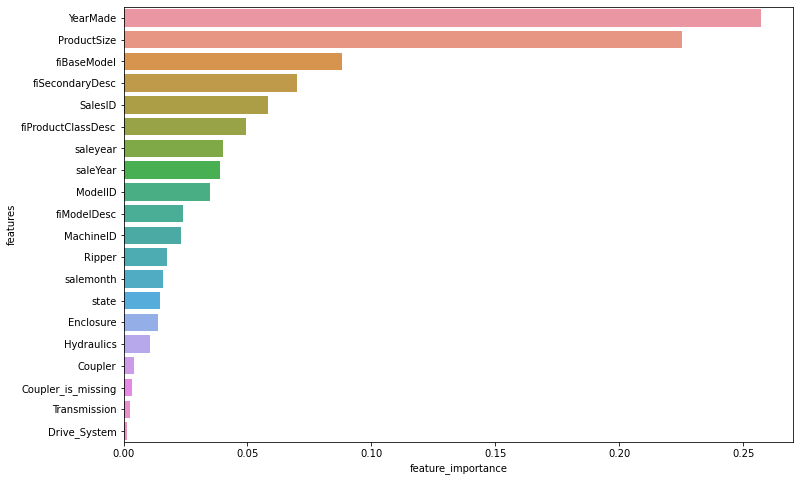

In [147]:
plt.figure(figsize=(12,8))
plot_features(X_train.columns, rf_model.feature_importances_)

## Year made and product size had the most importance as we can see